In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

In [2]:
import frugal_flows

In [3]:
from frugal_flows.flows import masked_independent_flow, masked_autoregressive_flow_first_uniform
from frugal_flows.bijections import UnivariateNormalCDF

In [4]:
from flowjax.distributions import Transformed, Uniform, _StandardUniform
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data
from flowjax.bijections.utils import Identity
from flowjax.wrappers import NonTrainable
from flowjax.bijections import (
    Affine,
    Invert,
    MaskedAutoregressive,
    RationalQuadraticSpline,
    Stack,
    Tanh,
)

In [6]:
SEED = 0

# Generate data

In [5]:
# gen data
# y = jr.normal(subkey, shape=(5000,1))

key, subkey = jr.split(jr.PRNGKey(0))

# x = jr.bernoulli(subkey, p=0.5, shape=(5000, 1))
# # x = jr.multivariate_normal(key, jnp.array([0.,0.]), jnp.array([[1., 0.8],[0.8, 1.]]), shape=(5000,))

key, subkey = jr.split(key)
y = jr.normal(subkey, shape=(5000,1)) #+ x

z = jr.multivariate_normal(key, jnp.array([0.,0.]), jnp.array([[1., 0.8],[0.8, 1.]]), shape=(5000,))

# Independent Marginal flows

 34%|██████████████████████████▋                                                   | 24/70 [00:08<00:15,  2.92it/s, train=2.875636, val=2.9463725 (Max patience reached)]


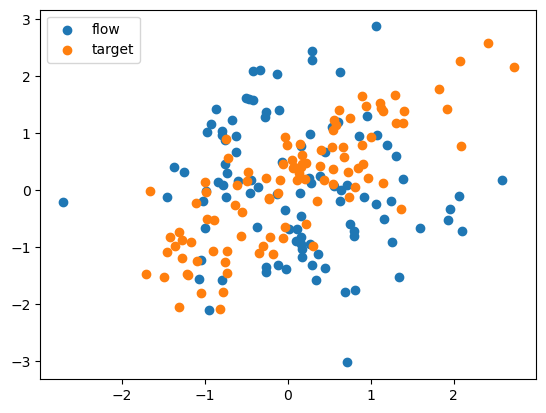

In [8]:
nvars = 2
key, subkey = jr.split(jr.PRNGKey(SEED + 1))

base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))

transformer = RationalQuadraticSpline(knots=8, interval=1)

flow = masked_independent_flow(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    ) # Support on [-1, 1]

flow = Transformed(
    flow, Invert(Tanh(flow.shape))
) # Unbounded support


flow = flow.merge_transforms()

assert isinstance(flow.base_dist, _StandardUniform)

flow = eqx.tree_at(
    where=lambda flow: flow.bijection.bijections[0],
    pytree=flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=z,
    learning_rate=1e-3,
    max_patience=10,
    max_epochs=70,
)

plt.scatter(*flow.sample(key, (100, )).T, label="flow")
plt.scatter(*z[:100].T, label="target")
plt.legend()

In [9]:
marginal_cdf = jax.vmap(flow.bijection.inverse, in_axes=(0,))

In [10]:
u_z = marginal_cdf(z)

# Copula flow given marginal

 74%|██████████████████████████████████████████████████████▉                   | 52/70 [00:14<00:04,  3.68it/s, train=-0.5452698, val=-0.47145706 (Max patience reached)]


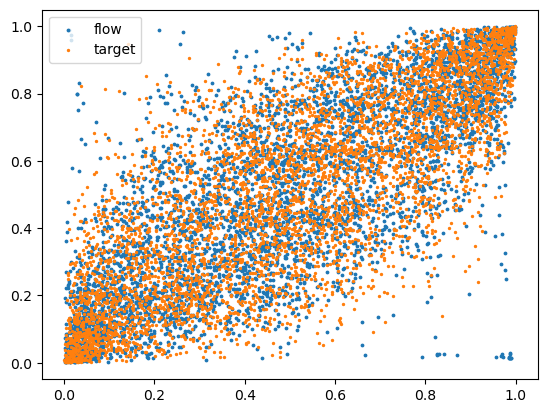

In [11]:
nvars = 2
key, subkey = jr.split(jr.PRNGKey(SEED + 2))

base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))

transformer = RationalQuadraticSpline(knots=8, interval=1)

copula_flow = masked_autoregressive_flow(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    ) # Support on [-1, 1]

copula_flow = Transformed(
    copula_flow, Invert(Affine(loc=-jnp.ones(nvars), scale=jnp.ones(nvars)*2))
) # Unbounded support


copula_flow = copula_flow.merge_transforms()

assert isinstance(copula_flow.base_dist, _StandardUniform)

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[0],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[-1],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
copula_flow, losses = fit_to_data(
    key=subkey,
    dist=copula_flow,
    x=u_z,
    learning_rate=1e-3,
    max_patience=10,
    max_epochs=70,
)

plt.scatter(*copula_flow.sample(key, (5000, )).T, label="flow", s=3)
plt.scatter(*u_z.T, label="target", s=2)
plt.legend()

In [12]:
inv_copula_cdf = jax.vmap(copula_flow.bijection.inverse, in_axes=(0,))
uu = inv_copula_cdf(u_z)

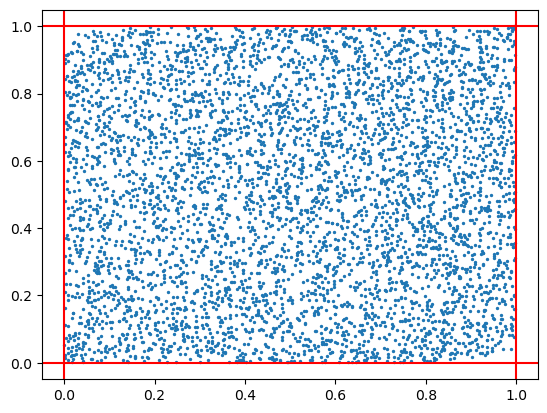

In [13]:
plt.scatter(*(uu.T), label="inverse flow", s=2,)
plt.axhline(0, color='red')
plt.axhline(1, color='red')
plt.axvline(0, color='red')
plt.axvline(1, color='red')
plt.show()

# copula flow + marginal Y|do(X) given other marginals

In [15]:
list_bijections = [UnivariateNormalCDF(ate=5., scale=2.)] + [Identity(())]*2  


marginal_transform = Stack(list_bijections)

nvars = 2
key, subkey = jr.split(jr.PRNGKey(SEED + 3))

base_dist = Uniform(-jnp.ones(nvars+1), jnp.ones(nvars+1))

transformer = RationalQuadraticSpline(knots=8, interval=1)

copula_flow = masked_autoregressive_flow_first_uniform(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    invert=True,
    # cond_dim=x.shape[1],
    ) # Support on [-1, 1]

copula_flow = Transformed(
    copula_flow, Invert(Affine(loc=-jnp.ones(nvars+1), scale=jnp.ones(nvars+1)*2))
) # Unbounded support



copula_flow = Transformed(
    copula_flow, Invert(marginal_transform),
) # Unbounded support


copula_flow = copula_flow.merge_transforms()

assert isinstance(copula_flow.base_dist, _StandardUniform)

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[0],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[-2],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
copula_flow, losses = fit_to_data(
    key=subkey,
    dist=copula_flow,
    x=jnp.hstack([y, u_z]),
    learning_rate=1e-3,
    max_patience=70,
    max_epochs=300,
    # condition=x,
)

 77%|████████████████████████████████████████████████████████▋                 | 230/300 [00:42<00:12,  5.48it/s, train=0.85332507, val=0.9314453 (Max patience reached)]


### samples from the copula flow 

In [16]:
copula_flow_samples = copula_flow.sample(key, (5000,))#, condition=u_1) #
copula_flow_samples.shape

(5000, 3)

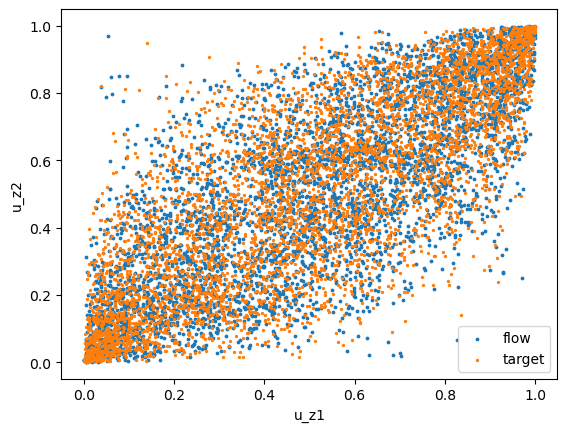

In [17]:
plt.scatter(*copula_flow_samples[:,1:].T, label="flow", s=3)
plt.scatter(*u_z.T, label="target", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

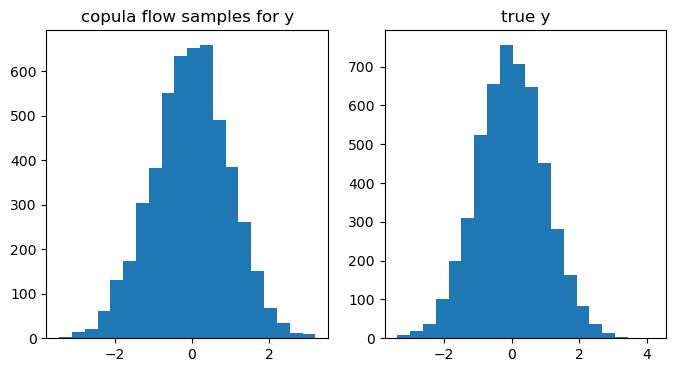

In [18]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].hist(copula_flow_samples[:,0], label="flow", bins=20)
ax[0].set_title('copula flow samples for y')

ax[1].hist(y.flatten(), label="flow", bins=20)
ax[1].set_title('true y')
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

In [19]:
copula_flow.bijection.bijections[-1].bijection.bijections[0].ate, copula_flow.bijection.bijections[-1].bijection.bijections[0].scale

(Array(-0.00964958, dtype=float32), Array(1.000965, dtype=float32))

### pushing base distribution through the flow

In [20]:
uni_s = jr.uniform(key, shape=(5000,3))

In [21]:
uni_m1p1 = jax.vmap(copula_flow.bijection.bijections[0].tree.transform)(uni_s)
corruni_m1p1 = jax.vmap(copula_flow.bijection.bijections[1].transform)(uni_m1p1) #, u_1)#, x)

In [22]:
corruni_01 = jax.vmap(copula_flow.bijection.bijections[2].tree.transform)(corruni_m1p1) #, u_1) #, x)

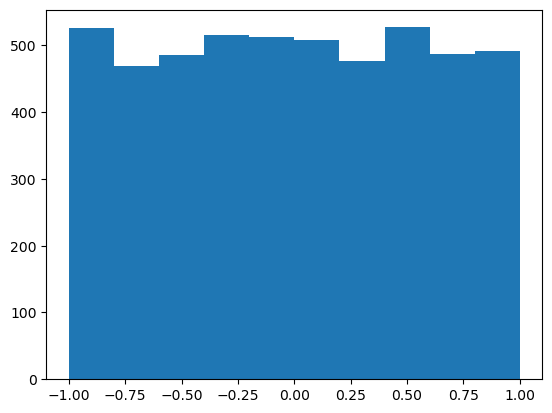

In [23]:
plt.hist(corruni_m1p1[:,0]);